# Plot peak shapes on Yeast2021 dataset by different software algorithms 

This is on the Yeast Neg data from Chen, Li, et al. "Metabolite discovery through global annotation of untargeted metabolomics data." Nature methods 18.11 (2021): 1377-1385.

- XCMS v3.18.0 (R 4.2.0)
- MZmine 2.53 (peak detection via centwave and local mininum)
- MS-Dial v4.90
- asari 1.10.6

SL 2023-01-21

In [1]:
!pip install --upgrade -q asari-metabolomics
!pip install --upgrade -q jms-metabolite-services

In [2]:
import pickle
import matplotlib.pyplot as plt
from numpy import log2
from asari.peaks import evaluate_gaussian_peak_on_intensity_list
from jms.search import build_centurion_tree, find_best_match_centurion_indexed_list

In [3]:
def get_features(infile, start_row=1, mz_col=0, rt_col=1, 
                 rt_left=2, rt_right=3,
                 shape=None,
                 sep='\t'):
    '''Read features from infile and return a list of json peaks.
    '''
    FL = []
    Gshape = 0
    ii = 0
    for line in open(infile).read().splitlines()[start_row:]:
        ii += 1
        a = line.split(sep)
        if shape:
            Gshape = float(a[shape])
        FL.append(
            {'id': 'row'+str(ii+start_row), 'mz': float(a[mz_col]), 
             'rtime': float(a[rt_col]),
             'rt_left': float(a[rt_left]),
             'rt_right': float(a[rt_right]),
             'shape': Gshape,
            }
        )
    return FL
    

In [4]:
xcms_ = get_features('YeastNeg2021_NetID_XCMS_featureTable.csv', start_row=1, mz_col=1, rt_col=4, rt_left=5, rt_right=6, sep=',')
print(len(xcms_), '\n', xcms_[:3])

6043 
 [{'id': 'row2', 'mz': 70.0640208883424, 'rtime': 145.47135925293, 'rt_left': 145.47135925293, 'rt_right': 145.47135925293, 'shape': 0}, {'id': 'row3', 'mz': 70.439044434384, 'rtime': 146.045, 'rt_left': 146.031768798828, 'rt_right': 146.045166015625, 'shape': 0}, {'id': 'row4', 'mz': 70.9460569198031, 'rtime': 406.291839599609, 'rt_left': 405.112243652344, 'rt_right': 406.872, 'shape': 0}]


In [75]:
asari_ = get_features('asari1.10.6_default_full_Feature_table.tsv', start_row=1, mz_col=1, rt_col=2, rt_left=3, rt_right=4, shape=8, sep='\t')
print(len(asari_), '\n', asari_[3])

5341 
 {'id': 'row5', 'mz': 108.0217, 'rtime': 175.23, 'rt_left': 168.4, 'rt_right': 182.11, 'shape': 0.87}


In [6]:
mzmine_L_ = get_features('exportrtrange_yeast2021_MZmine2.53_localminium_featureTable.csv', 
                               start_row=1, mz_col=1, rt_col=2, rt_left=6, rt_right=7, shape=None, sep=',')
for x in mzmine_L_:
    x['rtime'] = x['rtime']*60
    x['rt_left'] = x['rt_left']*60
    x['rt_right'] = x['rt_right']*60
    
print(len(mzmine_L_), '\n', mzmine_L_[3])

18155 
 {'id': 'row5', 'mz': 72.00908915201823, 'rtime': 780.358, 'rt_left': 776.109, 'rt_right': 787.542, 'shape': 0}


In [7]:
mzmine_ = get_features('exportrtrange_yeast2021_MZmine2.53_wavelets_featureTable.csv', 
                               start_row=1, mz_col=1, rt_col=2, rt_left=6, rt_right=7, shape=None, sep=',')
for x in mzmine_:
    x['rtime'] = x['rtime']*60
    x['rt_left'] = x['rt_left']*60
    x['rt_right'] = x['rt_right']*60
    
print(len(mzmine_), '\n', mzmine_[3])


11290 
 {'id': 'row5', 'mz': 71.05022430419922, 'rtime': 655.94, 'rt_left': 654.172, 'rt_right': 656.53, 'shape': 0}


# will add msdial

msdial_ = get_features('', start_row=6, mz_col=2, 
                       
                       
                       rt_col=1, sep='\t')




## How to evaluate peaks

We use the mass tracks from asari with 1E4 min peak height.

Match m/z of a feature by XCMS to a mass track. 
Use RT window from XCMS to get peak data points, 
and calculate peak height and goodness of Gaussian fitting.

Repeat for other processing methods.

Plot peak shape vs log2 height.

In [72]:
def get_track_id(mz, tracktree, ppm=5):
    '''return best matched mass track for mz.
    None if no match.
    '''
    return find_best_match_centurion_indexed_list(mz, tracktree, limit_ppm=ppm)

def remove_redundant(peaks, tracktree, ppm=5):
    '''return list of pairs, [(masstrack_id, peak), ...]
    fix masstrack id if needed.
    '''
    print("Input list", len(peaks))
    new, d = [], {}
    for peak in peaks:
        m_ = get_track_id(peak['mz'], tracktree)
        if m_:
            if m_['id_number'] in d:
                d[m_['id_number']].append(peak)
            else:
                d[m_['id_number']] = [peak]

    for k,v in d.items():
        v = compact_plist(v)
        for x in v:
            new.append( (k, x) )
            
    print("After removing redundancy", len(new))
    return new

def compact_plist(L):
    '''remove redundnat peaks in L'''
    if len(L) > 1:
        L = sorted( [(p['rtime'], p['id'], p) for p in L] )
        new = [L[0], ]
        for x in L[1:]:
            if abs(x[0] - new[-1][0]) > 6: # seconds
                new.append(x)
        return [x[2] for x in new]
    else:
        return L
        
                    
def extract_peak_info(peak, dict_scan_rtime, masstrack):
    '''update peak by height and goodness of fitting
    '''
    padding = 3
    l, r = peak['rt_left'] - padding, peak['rt_right'] + padding
    scans = sorted([k for k,v in dict_scan_rtime.items() if l <= v <= r])
    if len(scans) > 3:
        roi = masstrack['intensity'][scans]
        height = roi.max()
        right = len(scans) - 1
        apex = int(right/2)
        shape, _sigma = evaluate_gaussian_peak_on_intensity_list(roi, height, apex, 0, right)
    elif scans:
        roi = masstrack['intensity'][scans]
        height = roi.max()
        shape = 0
    else:
        height, shape = 10000, 0
    return height, shape
    

In [32]:
# mass tracks and most info are stored in cmap.pickle in asari processing
cmap = pickle.load(open('low_cmap.pickle', 'rb'))
cmap.keys()

dict_keys(['_number_of_samples_', 'rt_length', 'dict_scan_rtime', 'list_mass_tracks', 'MassGrid'])

In [33]:
dict_scan_rtime = cmap['dict_scan_rtime']
cmap = cmap['list_mass_tracks']

In [34]:
list(dict_scan_rtime.items())[:9]

[(0, 60.144800000000004),
 (1, 60.7342),
 (2, 61.31479999999999),
 (3, 61.8955),
 (4, 62.47580000000001),
 (5, 63.0544),
 (6, 63.6338),
 (7, 64.2127),
 (8, 64.7913)]

In [35]:
cmap[99]

{'id_number': 99,
 'mz': 76.96569442749023,
 'intensity': array([2956, 3920, 3613, ..., 7184, 2839, 2386])}

In [36]:
len(cmap.keys())

12207

In [37]:
tracktree = build_centurion_tree(list(cmap.values()))

In [38]:
get_track_id(76.968, tracktree)

{'id_number': 10191,
 'mz': 76.96812057495117,
 'intensity': array([   0,    0,    0, ...,    0, 7391, 3404])}

In [39]:
asari_[1000]

{'id': 'row1002',
 'mz': 146.1152,
 'rtime': 252.69,
 'rt_left': 248.17,
 'rt_right': 257.25,
 'shape': 1.0,
 'height': 310862}

In [40]:
get_track_id(146.1152, tracktree)

{'id_number': 2100,
 'mz': 146.11518096923828,
 'intensity': array([0, 0, 0, ..., 0, 0, 0])}

In [41]:
extract_peak_info(asari_[1000], dict_scan_rtime, cmap[1899])

/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/conda/lib/python3.10/site-packages/asari/peaks.py:310: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.sum((y_fitted-y_orignal)**2) / np.sum((y_orignal-np.mean(y_orignal))**2))


(0, nan)

### Plot asari

use internal goodness of fitting in asari. Peak narrower here.

In [42]:
shape_cut = 0.5
h_cut = log2(1000000)
markersize=0.5

In [76]:
x_good, y_good = [], []
x_poor, y_poor = [], []

for peak in asari_:
    m_ = get_track_id(peak['mz'], tracktree)
    if m_:
        h, r = extract_peak_info(peak, dict_scan_rtime, cmap[m_['id_number']])
        peak['height'] = h
        # peak['shape'] = r
        # r = peak['shape']
        if h > h_cut and r > shape_cut:
            x_good.append( r )
            y_good.append( log2(h) )
        elif h > 1000 and r > 0:
            x_poor.append( r )
            y_poor.append( log2(h+1) )


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/conda/lib/python3.10/site-packages/asari/peaks.py:310: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.sum((y_fitted-y_orignal)**2) / np.sum((y_orignal-np.mean(y_orignal))**2))


4637 525 5162


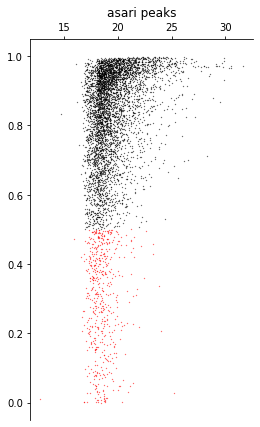

In [77]:
print(len(x_good), len(x_poor), len(x_good + x_poor))

fig, ax = plt.subplots(figsize=(4, 7))

# plt.figure(figsize=(4, 7))

ax.plot( y_good, x_good, 'k.', markersize=markersize)
ax.plot( y_poor, x_poor, 'r.', markersize=markersize)
# plt.tick_params(bottom='off', right='off', )
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)

ax.set_title("asari peaks")

ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

plt.savefig("asari_peaks" + ".png")
plt.savefig("asari_peaks" + ".pdf")

### plot XCMS

In [80]:
x_good, y_good = [], []
x_poor, y_poor = [], []

new = remove_redundant(xcms_, tracktree, ppm=5)
for mid, peak in new:
    h, r = extract_peak_info(peak, dict_scan_rtime, cmap[mid])

    peak['height'] = h
    peak['shape'] = r
    if h > h_cut and r > shape_cut:
        x_good.append( r )
        y_good.append( log2(h) )
    elif h > 1000 and r > 0:
        x_poor.append( r )
        y_poor.append( log2(h+1) )

print("input N", len(new),
      "good", len(x_good), "poor", len(x_poor), )

Input list 6043
After removing redundancy 5809
input N 5809 good 4566 poor 1024


4566 1024 5590


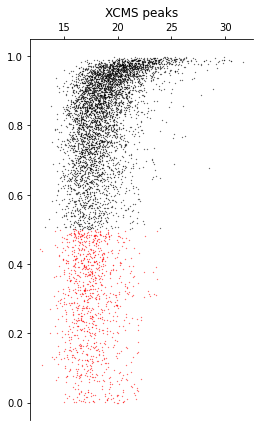

In [70]:
# Make figure
fig, ax = plt.subplots(figsize=(4, 7))
ax.plot( y_good, x_good, 'k.', markersize=markersize)
ax.plot( y_poor, x_poor, 'r.', markersize=markersize)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

ax.set_title("XCMS peaks")
plt.savefig("xcms_peaks" + ".png")
plt.savefig("xcms_peaks" + ".pdf")

### plot MZmine_

In [81]:
x_good, y_good = [], []
x_poor, y_poor = [], []

new = remove_redundant(mzmine_, tracktree, ppm=5)
for mid, peak in new:
    h, r = extract_peak_info(peak, dict_scan_rtime, cmap[mid])

    peak['height'] = h
    peak['shape'] = r
    if h > h_cut and r > shape_cut:
        x_good.append( r )
        y_good.append( log2(h) )
    elif h > 1000 and r > 0:
        x_poor.append( r )
        y_poor.append( log2(h+1) )
        
print("input N", len(new),
      "good", len(x_good), "poor", len(x_poor), )

Input list 11290
After removing redundancy 10876


/opt/conda/lib/python3.10/site-packages/scipy/optimize/_minpack_py.py:833: OptimizeWarning: Covariance of the parameters could not be estimated
  warnings.warn('Covariance of the parameters could not be estimated',
/opt/conda/lib/python3.10/site-packages/asari/peaks.py:310: RuntimeWarning: invalid value encountered in double_scalars
  return 1 - (np.sum((y_fitted-y_orignal)**2) / np.sum((y_orignal-np.mean(y_orignal))**2))


input N 10876 good 6841 poor 1257


6841 1257 8098


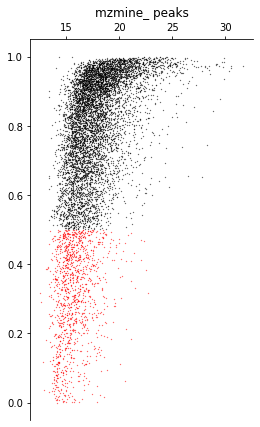

In [74]:

fig, ax = plt.subplots(figsize=(4, 7))
ax.plot( y_good, x_good, 'k.', markersize=markersize)
ax.plot( y_poor, x_poor, 'r.', markersize=markersize)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

ax.set_title("mzmine_ peaks")
plt.savefig("mzmine_peaks" + ".png")
plt.savefig("mzmine_peaks" + ".pdf")

### plot MZmine_L_

In [82]:
x_good, y_good = [], []
x_poor, y_poor = [], []

new = remove_redundant(mzmine_L_, tracktree, ppm=5)
for mid, peak in new:
    h, r = extract_peak_info(peak, dict_scan_rtime, cmap[mid])

    peak['height'] = h
    peak['shape'] = r
    if h > h_cut and r > shape_cut:
        x_good.append( r )
        y_good.append( log2(h) )
    elif h > 1000 and r > 0:
        x_poor.append( r )
        y_poor.append( log2(h+1) )
        
print("input N", len(new),
      "good", len(x_good), "poor", len(x_poor), )

Input list 18155
After removing redundancy 14394
input N 14394 good 4958 poor 2412


4958 2412 7370


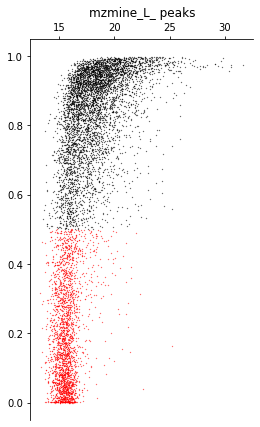

In [79]:

fig, ax = plt.subplots(figsize=(4, 7))
ax.plot( y_good, x_good, 'k.', markersize=markersize)
ax.plot( y_poor, x_poor, 'r.', markersize=markersize)
ax.spines['right'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.xaxis.tick_top()
ax.xaxis.set_label_position("top")

ax.set_title("mzmine_L_ peaks")

plt.savefig("mzmine_L_peaks" + ".png")
plt.savefig("mzmine_L_peaks" + ".pdf")

### plot MS-DIAL